# HW4: Big Data & Artificial Intelligence

## Load data

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('HW4_movie_metadata.csv')
data = data[data['num_critic_for_reviews'].notna()] # remove nan target variable
data.head()

In [0]:
# no color
columns = ['movie_title', 'duration', 'director_name', 'director_facebook_likes',
           'genres', 'actor_1_name', 'actor_1_facebook_likes',
           'actor_2_name', 'actor_2_facebook_likes', 
           'actor_3_name', 'actor_3_facebook_likes',
           'num_voted_users', 'cast_total_facebook_likes', 'language',
           'country', 'gross', 'budget', 'title_year', 'imdb_score', 'movie_facebook_likes',
           'num_critic_for_reviews']

# select only numerical data
use_col = ['duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'num_user_for_reviews',
           'actor_2_facebook_likes', 'actor_3_facebook_likes', 'num_voted_users',
           'cast_total_facebook_likes', 'gross', 'budget', 'imdb_score', 'movie_facebook_likes',
           'num_critic_for_reviews']

In [0]:
df = data[use_col]
df.reset_index(drop=True, inplace=True)

## Split data

### Stratified splitting

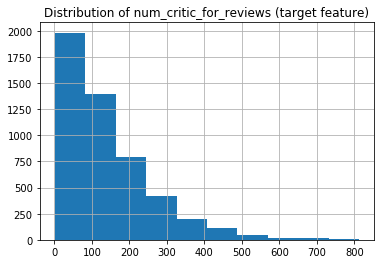

In [0]:
df['num_critic_for_reviews'].hist()
plt.title('Distribution of num_critic_for_reviews (target feature)')
plt.show()

#### split train-test

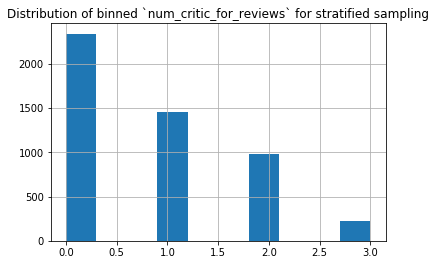

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

num_critics_cat = pd.cut(df['num_critic_for_reviews'], bins=[0, 100, 200, 400, np.inf], labels=[0,1,2,3])
num_critics_cat.hist()
plt.title('Distribution of binned `num_critic_for_reviews` for stratified sampling')

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_idx, test_idx in split.split(df, num_critics_cat):
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]

## Clean Data

### Fill NaN

In [0]:
df_train.isna().sum()

duration                       9
director_facebook_likes       82
actor_1_facebook_likes         5
num_user_for_reviews           0
actor_2_facebook_likes        10
actor_3_facebook_likes        16
num_voted_users                0
cast_total_facebook_likes      0
gross                        668
budget                       378
imdb_score                     0
movie_facebook_likes           0
num_critic_for_reviews         0
dtype: int64

In [0]:
def plot_stat(X, col):
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    X[col].hist(bins=50)
    plt.axvline(X[col].mean(), color='orange', label='mean')
    plt.axvline(X[col].median(), color='red', label='median')
    plt.axvline(X[col].mode()[0], color='green', label='mode')
    plt.title('{} histogram'.format(col))
    plt.legend()
    plt.subplot(122)
    X[col].plot.box()
    plt.title('{} box plot'.format(col))
    plt.show()
    print('There are {} NaN(s) for `{}`'.format(X[col].isna().sum(), col))

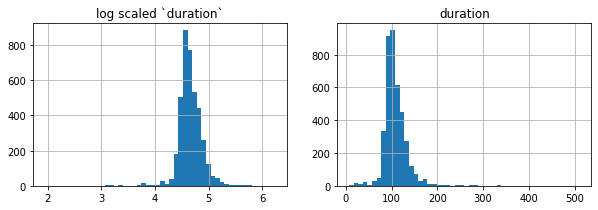

director_facebook_likes cannot log transform
actor_1_facebook_likes cannot log transform


/Users/chompk/.env/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

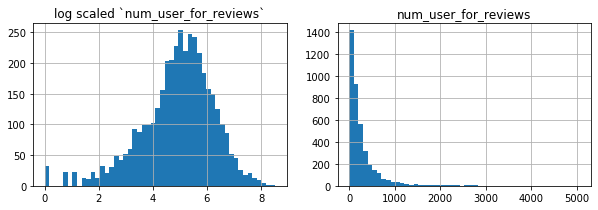

actor_2_facebook_likes cannot log transform
actor_3_facebook_likes cannot log transform


<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

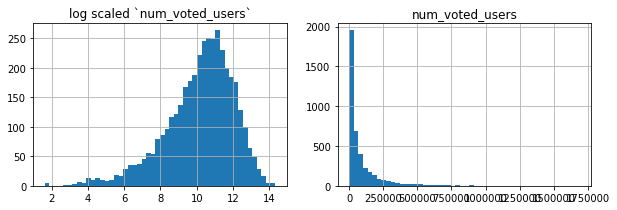

cast_total_facebook_likes cannot log transform


<Figure size 720x216 with 0 Axes>

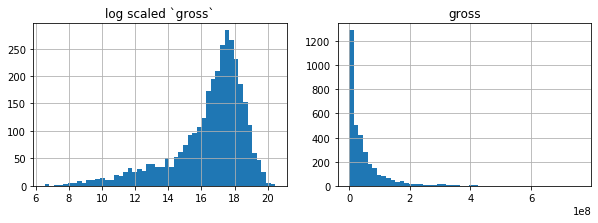

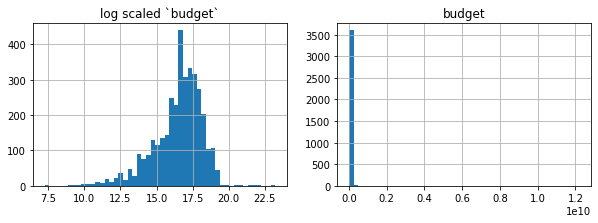

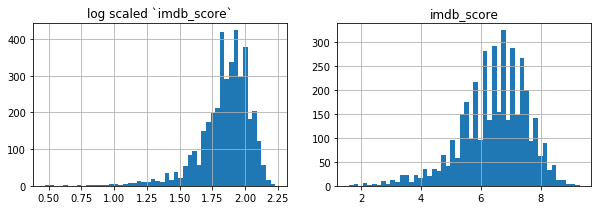

movie_facebook_likes cannot log transform


<Figure size 720x216 with 0 Axes>

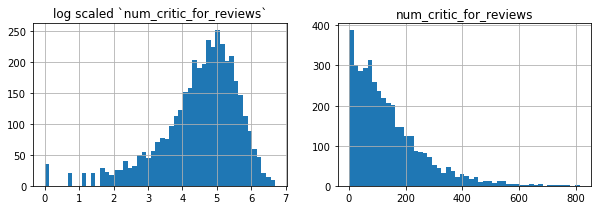

In [0]:
import numpy as np

for col in df_train:
    try:
        plt.figure(figsize=(10,3))
        plt.subplot(121)
        np.log(df_train[col]).hist(bins=50)
        plt.title('log scaled `{}`'.format(col))
        plt.subplot(122)
        df_train[col].hist(bins=50)
        plt.title(col)
        plt.show()
    except:
        plt.clf()
        print('{} cannot log transform'.format(col))

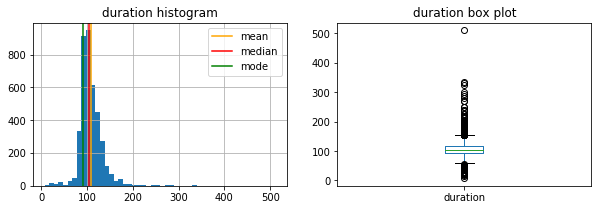

There are 9 NaN(s) for `duration`


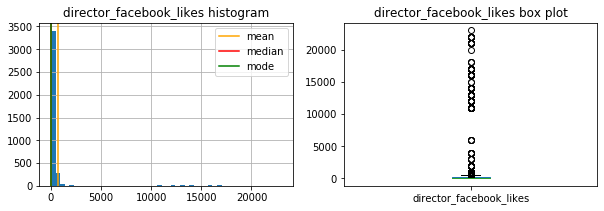

There are 82 NaN(s) for `director_facebook_likes`


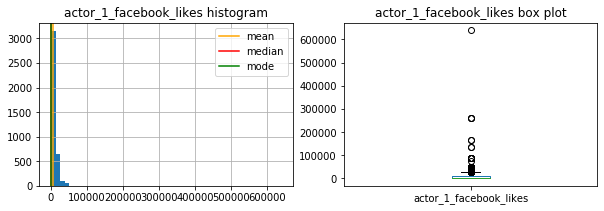

There are 5 NaN(s) for `actor_1_facebook_likes`


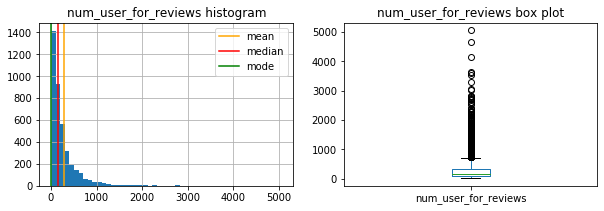

There are 0 NaN(s) for `num_user_for_reviews`


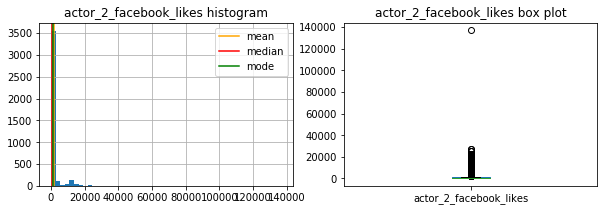

There are 10 NaN(s) for `actor_2_facebook_likes`


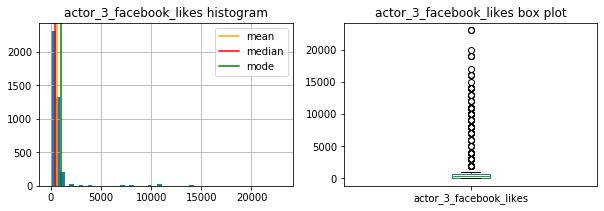

There are 16 NaN(s) for `actor_3_facebook_likes`


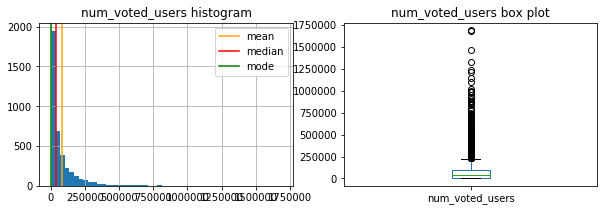

There are 0 NaN(s) for `num_voted_users`


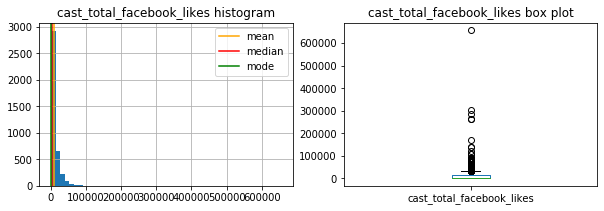

There are 0 NaN(s) for `cast_total_facebook_likes`


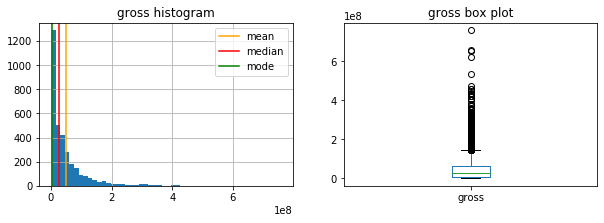

There are 668 NaN(s) for `gross`


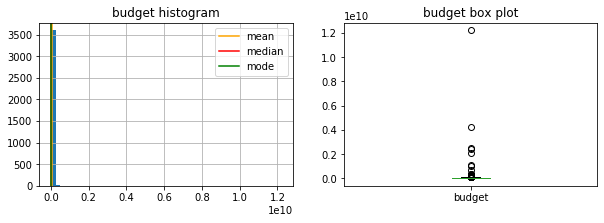

There are 378 NaN(s) for `budget`


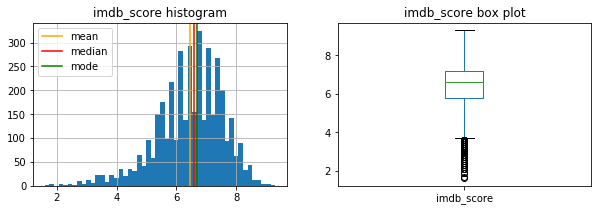

There are 0 NaN(s) for `imdb_score`


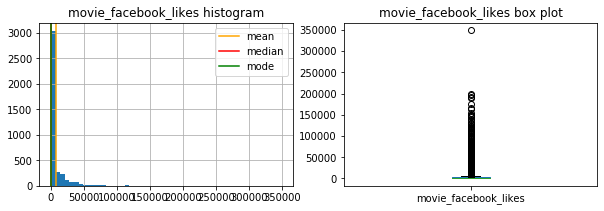

There are 0 NaN(s) for `movie_facebook_likes`


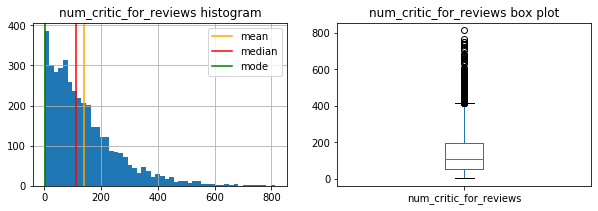

There are 0 NaN(s) for `num_critic_for_reviews`


In [0]:
for col in df_train:
    plot_stat(df_train, col)

Judging from the feature's statistic, it is safe to **fill all `NaN` with median**.

In [0]:
from sklearn.impute import SimpleImputer

median_imputer = SimpleImputer(strategy="median").fit(df_train)
train_data = median_imputer.transform(df_train)
test_data = median_imputer.transform(df_test)

df_train_no_nan = pd.DataFrame(train_data, columns=df_train.columns)
df_test_no_nan = pd.DataFrame(train_data, columns=df_test.columns)

In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_minmax = pd.DataFrame(MinMaxScaler().fit_transform(df_train_no_nan), columns=df_train_no_nan.columns)
df_standard = pd.DataFrame(StandardScaler().fit_transform(df_train_no_nan), columns=df_train_no_nan.columns)

X_minmax = df_minmax.iloc[:,:-1]
X_standard = df_standard.iloc[:,:-1]

y = df_train_no_nan['num_critic_for_reviews']

## Feature Selection

### Filter Method
Filter method consists of two steps:
1. Select significant features that have a strong correlation with dependent variable.
2. Eliminate any features that have a strong correlation to each other (as linear regression assume no collinearity)

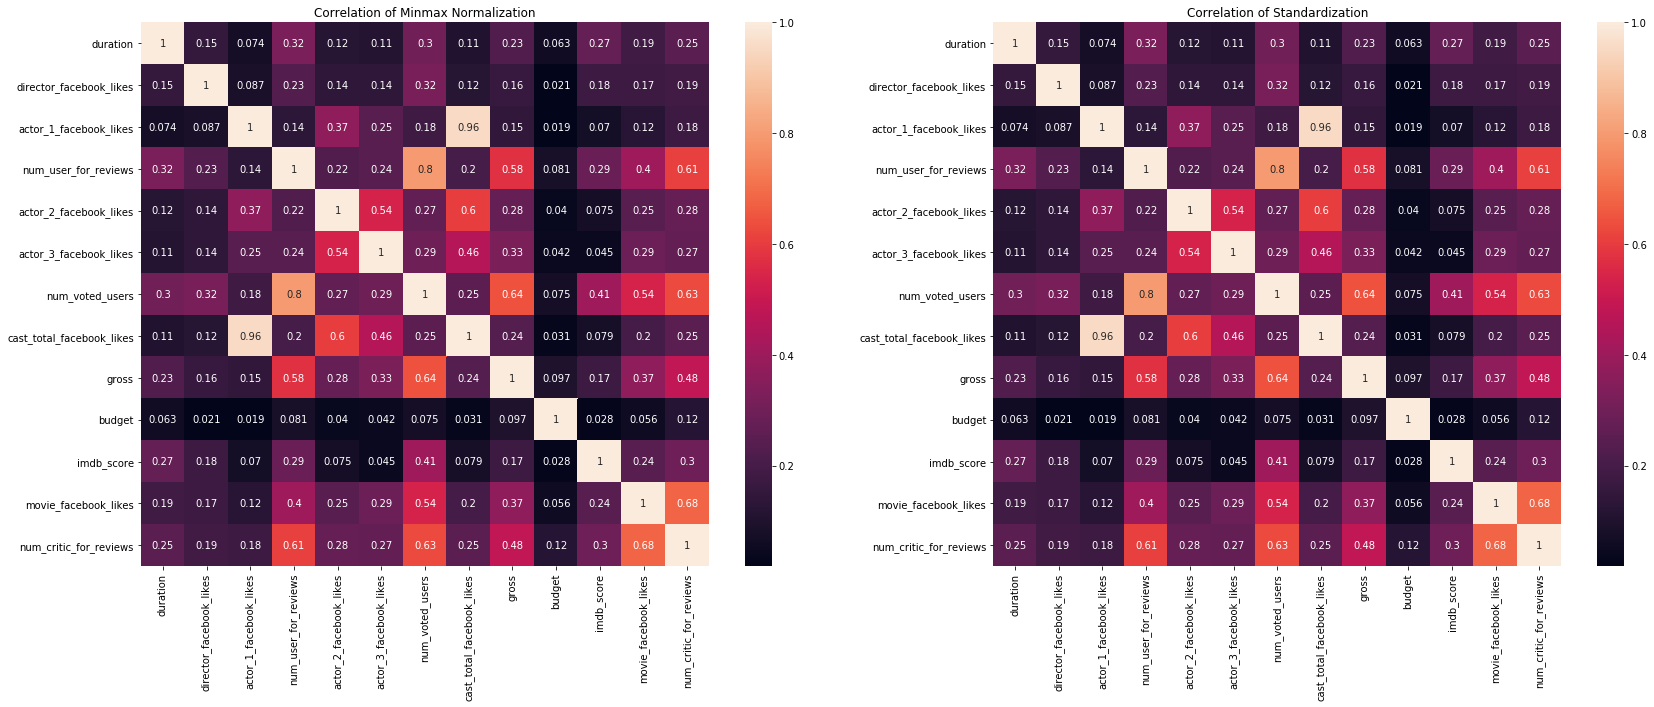

In [0]:
import seaborn as sns

corr_minmax = df_minmax.corr()
corr_standard = df_standard.corr()

plt.figure(figsize=(28,10))
plt.subplot(121)
plt.title('Correlation of Minmax Normalization')
sns.heatmap(corr_minmax, annot=True)
plt.subplot(122)
plt.title('Correlation of Standardization')
sns.heatmap(corr_standard, annot=True)
plt.show()
# plt.savefig('figures/corr_heat.png', bbox_inches = "tight")

In [0]:
corr_minmax[corr_minmax['num_critic_for_reviews'] > 0.5]['num_critic_for_reviews'][:-1]

num_user_for_reviews    0.609066
num_voted_users         0.630887
movie_facebook_likes    0.681387
Name: num_critic_for_reviews, dtype: float64

In [0]:
corr_standard[corr_standard['num_critic_for_reviews'] > 0.5]['num_critic_for_reviews'][:-1]

num_user_for_reviews    0.609066
num_voted_users         0.630887
movie_facebook_likes    0.681387
Name: num_critic_for_reviews, dtype: float64

In [0]:
df_minmax[['num_voted_users', 'movie_facebook_likes', 'num_user_for_reviews']].corr()

,num_voted_users,movie_facebook_likes,num_user_for_reviews
num_voted_users,1.000000,0.539526,0.800259
movie_facebook_likes,0.539526,1.000000,0.403099
num_user_for_reviews,0.800259,0.403099,1.000000


Since the correlation between `num_user_for_reviews` and `num_voted_users` are highly correlated, one feature will be dropped. In this case, `num_user_for_reviews` will be dropped because it's correlation to `num_critic_for_reviews` yield a slighly lower value.

In [0]:
df_standard[['num_voted_users', 'movie_facebook_likes', 'num_user_for_reviews']].corr()

,num_voted_users,movie_facebook_likes,num_user_for_reviews
num_voted_users,1.000000,0.539526,0.800259
movie_facebook_likes,0.539526,1.000000,0.403099
num_user_for_reviews,0.800259,0.403099,1.000000


In [0]:
selected_col_filter = ['num_voted_users', 'movie_facebook_likes']

### Stepwise Regression (Bidirectional Elimination)
Do both forward and backward elimination at the same time.

In [0]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    Source code from https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {} with p-value {}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.index[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {} with p-value {}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [0]:
selected_col_stepwise = stepwise_selection(X_minmax, y)
print('\nRemainding features: {}'.format(selected_col_stepwise))

Add  num_voted_users with p-value 0.0
Add  movie_facebook_likes with p-value 4.8240001823901767e-278
Add  num_user_for_reviews with p-value 1.5006687613138284e-82
Add  cast_total_facebook_likes with p-value 2.2434166666818654e-10
Add  gross with p-value 5.38279516066656e-08
Add  imdb_score with p-value 1.1309935650213841e-07
Drop num_voted_users with p-value 0.290829540465314
Add  budget with p-value 4.205448497925191e-07

Remainding features: ['movie_facebook_likes', 'num_user_for_reviews', 'cast_total_facebook_likes', 'gross', 'imdb_score', 'budget']


In [0]:
selected_col_stepwise = stepwise_selection(X_standard, y)
print('\nRemainding features: {}'.format(selected_col_stepwise))

Add  num_voted_users with p-value 0.0
Add  movie_facebook_likes with p-value 4.824000182391275e-278
Add  num_user_for_reviews with p-value 1.500668761313486e-82
Add  cast_total_facebook_likes with p-value 2.2434166666818082e-10
Add  gross with p-value 5.3827951606676044e-08
Add  imdb_score with p-value 1.1309935650213695e-07
Drop num_voted_users with p-value 0.2908295404653196
Add  budget with p-value 4.205448497924929e-07

Remainding features: ['movie_facebook_likes', 'num_user_for_reviews', 'cast_total_facebook_likes', 'gross', 'imdb_score', 'budget']


### Chi-Square Test
Hypothesis testing of dependence between input `X` and output `y` using chi-square test.

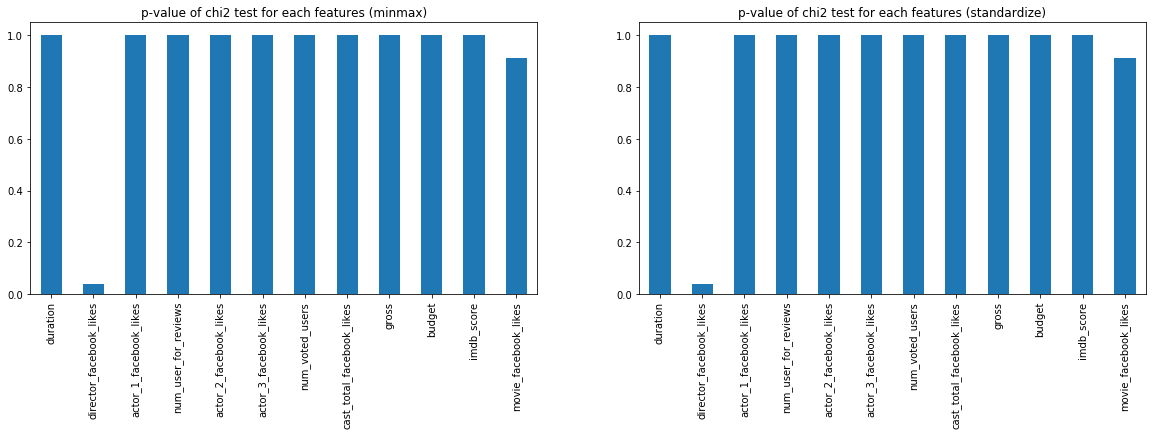

In [0]:
from sklearn.feature_selection import chi2, SelectKBest

plt.figure(figsize=(20,5))
plt.subplot(121)
chi_scores = chi2(X_minmax, y)
p_values = pd.Series(chi_scores[1], index=X_minmax.columns)
p_values.plot.bar()
plt.title('p-value of chi2 test for each features (minmax)')
plt.subplot(122)
chi_scores = chi2(MinMaxScaler().fit_transform(X_standard), y)
p_values = pd.Series(chi_scores[1], index=X_standard.columns)
p_values.plot.bar()
plt.title('p-value of chi2 test for each features (standardize)')
plt.show()

In [0]:
selected_col_chi2 = ['director_facebook_likes']

## Data Pipeline

In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [0]:
from sklearn.metrics import mean_squared_error

def run_pipeline(train_data, test_data):
    X_train, y_train = train_data
    X_test, y_test = test_data
    
    median_imputer = SimpleImputer(strategy='median')
    minmax_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()
    linreg = LinearRegression()

    minmax_pipeline = Pipeline([('median_impute', median_imputer),
                                ('minmax_scaler', minmax_scaler),
                                ('linear_regression', linreg)])
    standard_pipeline = Pipeline([('median_impute', median_imputer),
                                  ('standard_scaler', standard_scaler),
                                  ('linear_regression', linreg)])
    
    minmax_pipeline.fit(X_train, y_train)
    standard_pipeline.fit(X_train, y_train)
    minmax_rmse = mean_squared_error(y_test, minmax_pipeline.predict(X_test))**0.5
    standard_rmse = mean_squared_error(y_test, standard_pipeline.predict(X_test))**0.5
    print('\tMinmax Pipeline RMSE: {}'.format(minmax_rmse))
    print('\tStandardize Pipeline RMSE: {}'.format(standard_rmse))
    
    return minmax_pipeline, standard_pipeline

## Evaluation

In [0]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [0]:
print('='*5, 'No Feature Selection', '='*5)
pipeline_minmax, pipeline_standard = run_pipeline((X_train, y_train), (X_test, y_test))

print('='*5, 'Filtering Method', '='*5)
filter_pipeline_minmax, filter_pipeline_standard = run_pipeline((X_train[selected_col_filter], y_train), (X_test[selected_col_filter], y_test))

print('='*5, 'Stepwise Regression', '='*5)
stepwise_pipeline_minmax, stepwise_pipeline_standard = run_pipeline((X_train[selected_col_stepwise], y_train), (X_test[selected_col_stepwise], y_test))

print('='*5, 'Chi2 Feature Selection', '='*5)
chi2_pipeline_minmax, chi2_pipeline_standard = run_pipeline((X_train[selected_col_chi2], y_train), (X_test[selected_col_chi2], y_test))

===== No Feature Selection =====
	Minmax Pipeline RMSE: 115.6783165370636
	Standardize Pipeline RMSE: 72.81609973252895
===== Filtering Method =====
	Minmax Pipeline RMSE: 115.66020128121538
	Standardize Pipeline RMSE: 80.2107534161353
===== Stepwise Regression =====
	Minmax Pipeline RMSE: 115.68171672855158
	Standardize Pipeline RMSE: 72.71945110086611
===== Chi2 Feature Selection =====
	Minmax Pipeline RMSE: 119.5561988347664
	Standardize Pipeline RMSE: 118.58819557126553


## Visualize Prediction

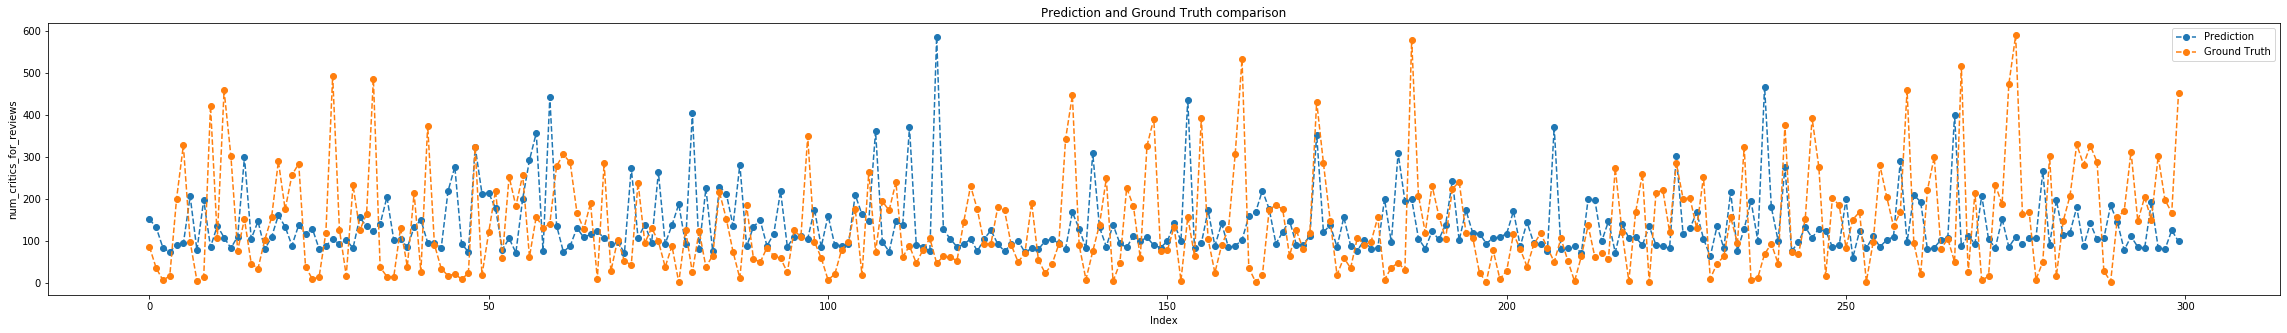

In [0]:
plt.figure(figsize=(40,5))
plt.plot(pipeline_standard.predict(X_train)[:300], 'o--', label='Prediction')
plt.plot(y_test.reset_index(drop=True)[:300], 'o--', label='Ground Truth')
plt.title('Prediction and Ground Truth comparison')
plt.ylabel('num_critics_for_reviews')
plt.xlabel('Index')
plt.legend()
plt.show()

## Features Importance

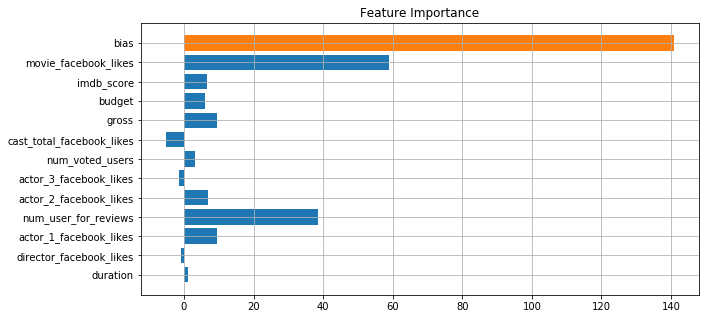

In [0]:
plt.figure(figsize=(10,5))
plt.barh(X_train.columns, pipeline_standard.named_steps['linear_regression'].coef_)
plt.barh('bias', pipeline_standard.named_steps['linear_regression'].intercept_)
plt.grid()
plt.title('Feature Importance')
plt.show()

## Polynomial Features (degree=2)

In [0]:
from sklearn.preprocessing import PolynomialFeatures

def run_poly_pipeline(train_data, test_data):
    X_train, y_train = train_data
    X_test, y_test = test_data

    median_imputer = SimpleImputer(strategy='median')
    minmax_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()
    linreg = LinearRegression()
    poly = PolynomialFeatures()

    minmax_pipeline = Pipeline([('median_impute', median_imputer),
                                ('poly_features', poly),
                                ('minmax_scaler', minmax_scaler),
                                ('linear_regression', linreg)])
    standard_pipeline = Pipeline([('median_impute', median_imputer),
                                  ('poly_features', poly),
                                  ('standard_scaler', standard_scaler),
                                  ('linear_regression', linreg)])

    minmax_pipeline.fit(X_train, y_train)
    standard_pipeline.fit(X_train, y_train)
    minmax_rmse = mean_squared_error(y_test, minmax_pipeline.predict(X_test))**0.5
    standard_rmse = mean_squared_error(y_test, standard_pipeline.predict(X_test))**0.5
    print('\tMinmax Pipeline RMSE: {}'.format(minmax_rmse))
    print('\tStandardize Pipeline RMSE: {}'.format(standard_rmse))

    return minmax_pipeline, standard_pipeline

In [0]:
print('='*5, 'No Feature Selection', '='*5)
poly_pipeline_minmax, poly_pipeline_standard = run_poly_pipeline((X_train, y_train), (X_test, y_test))

print('='*5, 'Filtering Method', '='*5)
poly_filter_pipeline_minmax, poly_filter_pipeline_standard = run_poly_pipeline((X_train[selected_col_filter], y_train), (X_test[selected_col_filter], y_test))

print('='*5, 'Stepwise Regression', '='*5)
poly_stepwise_pipeline_minmax, poly_stepwise_pipeline_standard = run_poly_pipeline((X_train[selected_col_stepwise], y_train), (X_test[selected_col_stepwise], y_test))

print('='*5, 'Chi2 Feature Selection', '='*5)
poly_chi2_pipeline_minmax, poly_chi2_pipeline_standard = run_poly_pipeline((X_train[selected_col_chi2], y_train), (X_test[selected_col_chi2], y_test))

===== No Feature Selection =====
	Minmax Pipeline RMSE: 113.15996711609002
	Standardize Pipeline RMSE: 61.74488790780544
===== Filtering Method =====
	Minmax Pipeline RMSE: 113.70443735535814
	Standardize Pipeline RMSE: 70.71883568860176
===== Stepwise Regression =====
	Minmax Pipeline RMSE: 116.44889965271337
	Standardize Pipeline RMSE: 64.30595234352813
===== Chi2 Feature Selection =====
	Minmax Pipeline RMSE: 119.55474628353976
	Standardize Pipeline RMSE: 118.58624878902461


## Visualize Prediction (Polynomial Regression)

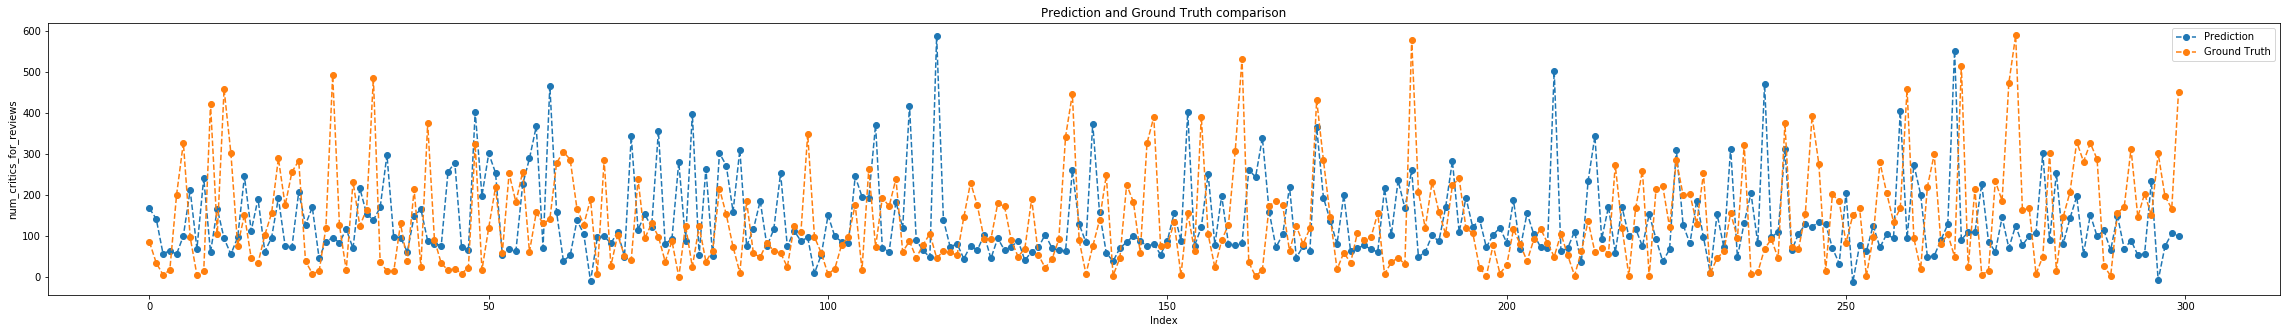

In [0]:
plt.figure(figsize=(40,5))
plt.plot(poly_pipeline_standard.predict(X_train)[:300], 'o--', label='Prediction')
plt.plot(y_test.reset_index(drop=True)[:300], 'o--', label='Ground Truth')
plt.title('Prediction and Ground Truth comparison')
plt.ylabel('num_critics_for_reviews')
plt.xlabel('Index')
plt.legend()
plt.show()